In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import scipy.stats as stats
import statsmodels.formula.api as sm

print(pd.__version__)

%matplotlib inline

0.22.0


In [165]:
# Read table

train_df = pd.read_table("./train.tsv", index_col = 'train_id', dtype = {'item_condition_id':CategoricalDtype(categories = [str(i) for i in range(1,6)], ordered = True), 'category_name':'category', 'brand_name': 'category', 'shipping':'category'})

/Users/Abe/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [166]:
# Create columns for the first three hierarchical levels represented in the category name column.
# Levels greater than one contain the names of the parent levels with the current level, separeated by slashes

a, b, c, d = train_df['category_name'].str.split("/", 3).str
category_oneLevel = a
category_twoLevel = a + "/" + b
category_threeLevel = a + "/" + b + "/" + c
train_df['category_oneLevel'] = category_oneLevel
train_df['category_twoLevel'] = category_twoLevel
train_df['category_threeLevel'] = category_threeLevel
for col in ['category_oneLevel', 'category_twoLevel', 'category_threeLevel']:
    train_df[col] = train_df[col].astype('category')


In [167]:
# The categories of the first category level

for i in train_df.category_oneLevel.cat.categories.values:
    print(i)

Beauty
Electronics
Handmade
Home
Kids
Men
Other
Sports & Outdoors
Vintage & Collectibles
Women


In [168]:
# The path of each category in the second level

for i in train_df.category_twoLevel.cat.categories.values:
    print(i)

Beauty/Bath & Body
Beauty/Fragrance
Beauty/Hair Care
Beauty/Makeup
Beauty/Other
Beauty/Skin Care
Beauty/Tools & Accessories
Electronics/Cameras & Photography
Electronics/Car Audio, Video & GPS
Electronics/Cell Phones & Accessories
Electronics/Computers & Tablets
Electronics/Media
Electronics/Other
Electronics/TV, Audio & Surveillance
Electronics/Video Games & Consoles
Handmade/Accessories
Handmade/Art
Handmade/Bags and Purses
Handmade/Books and Zines
Handmade/Candles
Handmade/Ceramics and Pottery
Handmade/Children
Handmade/Clothing
Handmade/Crochet
Handmade/Dolls and Miniatures
Handmade/Furniture
Handmade/Geekery
Handmade/Glass
Handmade/Holidays
Handmade/Housewares
Handmade/Jewelry
Handmade/Knitting
Handmade/Music
Handmade/Needlecraft
Handmade/Other
Handmade/Others
Handmade/Paper Goods
Handmade/Patterns
Handmade/Pets
Handmade/Quilts
Handmade/Toys
Handmade/Weddings
Handmade/Woodworking
Home/Artwork
Home/Bath
Home/Bedding
Home/Cleaning Supplies
Home/Furniture
Home/Home Appliances
Home/Ho

In [169]:
# The first few rows of the training data
train_df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_oneLevel,category_twoLevel,category_threeLevel
train_id,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Men/Tops,Men/Tops/T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Electronics/Computers & Tablets,Electronics/Computers & Tablets/Components & P...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Women/Tops & Blouses,Women/Tops & Blouses/Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home/Home Décor,Home/Home Décor/Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Women/Jewelry,Women/Jewelry/Necklaces


In [170]:
# Create column for (adult) clothing type that does not distinguish gender
# NaN's stand for all the items that are not clothing, or have no category (but could be clothing anyway)
# Note: This probably could have been dong without try-except

def get_clothing_type(elem):
    try:
        cat = elem['category_name'].split("/")
        if cat[0] in ['Men', 'Women']: return cat[1]
        else: return np.nan  
    except AttributeError: return np.nan # This error means that the category_name was NaN in the first place

train_df['clothing_type'] = train_df.apply(get_clothing_type, axis = 1).astype('category')


In [171]:
# The first few rows of the training data with the new transformed columns

train_df.head(20)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_oneLevel,category_twoLevel,category_threeLevel,clothing_type
train_id,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Men/Tops,Men/Tops/T-shirts,Tops
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Electronics/Computers & Tablets,Electronics/Computers & Tablets/Components & P...,NaN
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Women/Tops & Blouses,Women/Tops & Blouses/Blouse,Tops & Blouses
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home/Home Décor,Home/Home Décor/Home Décor Accents,NaN
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Women/Jewelry,Women/Jewelry/Necklaces,Jewelry
5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",Women,Women/Other,Women/Other/Other,Other
6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Women/Swimwear,Women/Swimwear/Two-Piece,Swimwear
7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Sports & Outdoors/Apparel,Sports & Outdoors/Apparel/Girls,NaN
8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Sports & Outdoors/Apparel,Sports & Outdoors/Apparel/Girls,NaN


In [172]:
# Basic statistics about price, the only numerical category in the data

train_df.describe()

,price
count,1.482535e+06
mean,2.673752e+01
std,3.858607e+01
min,0.000000e+00
25%,1.000000e+01
50%,1.700000e+01
75%,2.900000e+01
max,2.009000e+03


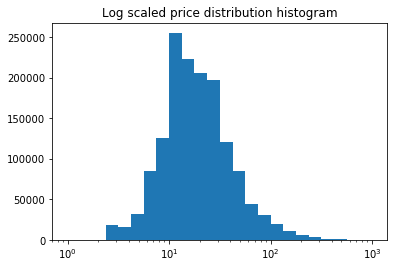

In [173]:
# A logarithmically scaled histogram of the price distribution

plt.hist(train_df.price[train_df.price > 0], bins=10**np.linspace(0, 3, 25))
plt.title('Log scaled price distribution histogram')
plt.xscale('log') 
plt.show() 

((array([-4.90471412, -4.72767087, -4.63203236, ...,  4.63203236,
          4.72767087,  4.90471412]),
  array([1.09861229, 1.09861229, 1.09861229, ..., 7.60290046, 7.60389797,
         7.60539236])),
 (0.78126453350128, 2.9129305217149466, 0.9902626442410368))

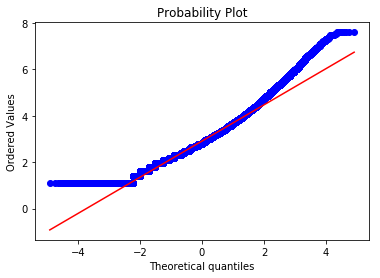

In [174]:
# This probability plot tests whether log-transformed prices are normally distributed.
# They seem to be heavy-tailed on the right, which is a pattern that mirrors pricing in financial markets (leptokurtosis)
# The heavy right tail is also visible in the histogram above
stats.probplot(np.log(train_df.price[train_df.price > 0]), dist = 'norm', plot = plt)

In [175]:
# The number of items with each item condition category
train_df.item_condition_id.value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

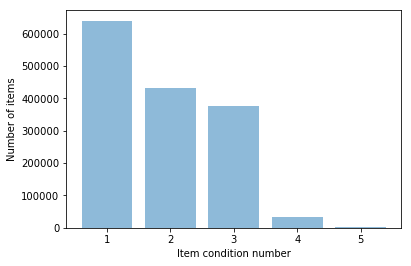

In [176]:
# A bar plot of the number of items with each item condition category, graphical representation of the above cell
# I think pandas has a simplier method for a categorical series object, I'm not sure I needed to set this up myself in matplotlib

y_pos = np.arange(len(train_df.item_condition_id.value_counts()))
plt.bar(y_pos, train_df.item_condition_id.value_counts(), align='center', alpha=0.5)
plt.xticks(y_pos, train_df.item_condition_id.cat.categories.values)
plt.ylabel('Number of items')
plt.xlabel('Item condition number')

In [228]:
# The next goal is to figure out, within each category, and then as a whole, the proportion of the error that can be eliminated by specifying the category.
# Based on intuition from visual inspection of the names of the categories, it seems that specifying the second level category plausibly eliminates much of the error.

# Need to consolidate logs so this function goes faster

'''
def get_group_stats(group_like): #Takes group or Series - but it needs to be made into two functions for each input type, because as it is you have to many if's
    
        log_group_like = group_like.transform(lambda y: np.log(y + 1))
    if isinstance(group_like, pd.core.groupby.SeriesGroupBy):
       # log_group_stats = log_group_st
    
    # Log ones need to be counted groupwise
    mean_raw = group_like.mean()
    mean_log = log_group_like.mean()
    std_log = log_group_like.std()
    sem_log = std_log/log_group_like.count()
    
    group_stats_dict = {'mean' : mean_raw, 'mean log': mean_log, 'std log' : std_log, 'sem log' : sem_log}
    
    if isinstance(group_like, pd.core.groupby.SeriesGroupBy):
        group_stats = pd.DataFrame(group_stats_dict)
    elif isinstance(group_like, pd.core.series.Series):
        group_stats = pd.Series(group_stats_dict)
    else:
        raise Exception('Must be Series or Grouped Series')
    
    return group_stats
''' 

new_df = train_df.drop('category_twoLevel', axis = 1).assign(category_twoLevel = train_df.category_twoLevel.cat.add_categories('NaN').fillna('NaN'))
new_df = new_df.assign(log_price = np.log(new_df.price + 1))

# Log price stats for whole dataset
price_stats = pd.Series({'mean' : new_df.price.mean(), 'mean log': new_df.log_price.mean(), 'std log' : new_df.log_price.std(), 'sem log' : new_df.log_price.std()/new_df.log_price.count()})
#price_stats = get_group_stats(train_df.price)

# Log price stats for each category - must add transform
grouped_df = new_df.groupby('category_twoLevel')
stats_dict = {'mean' : grouped_df.price.mean(), 'mean log': grouped_df.log_price.mean(), 'std log' : grouped_df.log_price.std(), 'sem log' : grouped_df.log_price.std()/grouped_df.log_price.count()}
category2_price_stats = pd.DataFrame(stats_dict)
#category2_price_stats = get_group_stats(train_df.drop('category_twoLevel', axis = 1).assign(category_twoLevel = train_df.category_twoLevel.cat.add_categories('NaN').fillna('NaN')).groupby('category_twoLevel').price)

print(price_stats)
print(category2_price_stats)

mean        2.673752e+01
mean log    2.979059e+00
sem log     5.053570e-07
std log     7.492094e-01
dtype: float64
                                            mean  mean log   sem log   std log
category_twoLevel                                                             
Beauty/Bath & Body                     19.084687  2.767214  0.000084  0.652202
Beauty/Fragrance                       23.801062  2.989748  0.000026  0.639170
Beauty/Hair Care                       19.374646  2.815232  0.000077  0.598025
Beauty/Makeup                          18.686176  2.767961  0.000005  0.612341
Beauty/Other                           22.952965  2.812244  0.001529  0.747466
Beauty/Skin Care                       20.497721  2.798968  0.000023  0.671997
Beauty/Tools & Accessories             19.907468  2.770611  0.000052  0.675898
Electronics/Cameras & Photography      71.343813  3.742712  0.000249  0.989426
Electronics/Car Audio, Video & GPS     37.874031  3.324236  0.001540  0.794456
Electronics/Cell

In [230]:
# Planning to regress price on the category names
# This needs to be changed to log price as is done with the rest of this notebook
result = sm.ols(formula = 'log_price ~ category_twoLevel', data = new_df).fit()
result.summary()

KeyboardInterrupt: 